In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import graphviz

import sys

sys.path.append('../src')  # lägg till src i sökvägarna

from data_preprocessing import df, df_scaled, X_scaled, y

np.random.seed(1)

trainIndex = np.random.choice(X_scaled.shape[0], size=int(len(X_scaled)*.75), replace=False)
X_scaled_train = X_scaled.iloc[trainIndex]
y_train = y.iloc[trainIndex]

X_scaled_test = X_scaled.drop(trainIndex)
y_test = y.drop(trainIndex)

       summertime          temp           dew      humidity        precip  \
count  1600.00000  1.600000e+03  1.600000e+03  1.600000e+03  1.600000e+03   
mean      0.64375 -6.883383e-17 -8.881784e-18 -5.329071e-17 -1.332268e-17   
std       0.47904  1.000313e+00  1.000313e+00  1.000313e+00  1.000313e+00   
min       0.00000 -2.624768e+00 -2.608989e+00 -2.520668e+00 -1.326092e-01   
25%       0.00000 -8.108835e-01 -8.530852e-01 -8.432055e-01 -1.326092e-01   
50%       1.00000  3.127737e-02  5.479718e-02  6.538701e-02 -1.326092e-01   
75%       1.00000  8.626413e-01  9.028192e-01  8.402859e-01 -1.326092e-01   
max       1.00000  2.201461e+00  1.651074e+00  1.885456e+00  2.797851e+01   

          windspeed    cloudcover    visibility     month_sin     month_cos  \
count  1.600000e+03  1.600000e+03  1.600000e+03  1.600000e+03  1.600000e+03   
mean   5.107026e-17  1.332268e-16  7.904788e-16  2.553513e-17  3.108624e-17   
std    1.000313e+00  1.000313e+00  1.000313e+00  1.000313e+00  1.0003

In [3]:
model = tree.DecisionTreeClassifier(max_leaf_nodes=5)
model.fit(X_scaled_train, y_train)
y_predict = model.predict(X_scaled_test)
print("Test error rate is %.3f" % np.mean(y_predict != y_test))
pd.crosstab(y_test, y_predict, rownames=['Actual'], colnames=['Predicted'], margins=True)
# pd.Series(model.feature_importances_, index=X_scaled_train.columns).sort_values(ascending=False)


Test error rate is 0.125


Predicted,high_bike_demand,low_bike_demand,All
Actual,,,
high_bike_demand,39,33,72
low_bike_demand,17,311,328
All,56,344,400


In [4]:
# Basmodell
base_model = tree.DecisionTreeClassifier(max_depth=5)

# Bagging med 100 träd
model = BaggingClassifier(
    base_model,
    n_estimators=100,          # antal bagged modeller
    max_samples=0.8,           # varje modell tränas på 80% av data (slumpmässigt)
    max_features=1.0,          # varje modell använder alla features
    bootstrap=True,            # sampling med återläggning
    random_state=42
)
model.fit(X_scaled_train, y_train)
y_predict = model.predict(X_scaled_test)
print("Test error rate is %.3f" % np.mean(y_predict != y_test))
pd.crosstab(y_test, y_predict, rownames=['Actual'], colnames=['Predicted'], margins=True)

Test error rate is 0.095


Predicted,high_bike_demand,low_bike_demand,All
Actual,,,
high_bike_demand,47,25,72
low_bike_demand,13,315,328
All,60,340,400


In [10]:
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=1
)
model.fit(X_scaled_train, y_train)
y_predict = model.predict(X_scaled_test)
print("Test error rate is %.3f" % np.mean(y_predict != y_test))
pd.crosstab(y_test, y_predict, rownames=['Actual'], colnames=['Predicted'], margins=True)

Test error rate is 0.100


Predicted,high_bike_demand,low_bike_demand,All
Actual,,,
high_bike_demand,46,26,72
low_bike_demand,14,314,328
All,60,340,400


In [6]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_scaled_train, y_train, cv=10, scoring='accuracy')
print("Cross-validation accuracy scores:", scores)
print("Mean cross-validation accuracy: %.3f" % np.mean(scores))

Cross-validation accuracy scores: [0.88333333 0.875      0.89166667 0.90833333 0.875      0.90833333
 0.875      0.89166667 0.86666667 0.9       ]
Mean cross-validation accuracy: 0.887


In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', None]
}

rf = RandomForestClassifier(random_state=42)

grid = GridSearchCV(rf, param_grid, cv=5, scoring='f1_macro')
grid.fit(X_scaled_train, y_train)

print(grid.best_params_)


{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 300}


In [ ]:
# Bästa modell från grid search
from sklearn.model_selection import cross_val_score
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features=None,
    class_weight={'high_bike_demand': 1, 'low_bike_demand': 1},
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=1
)
#scores = cross_val_score(model, X_scaled_train, y_train, cv=5, scoring='f1_macro')
#print("Cross-validation accuracy scores:", scores)
#print("Mean cross-validation accuracy: %.3f" % np.mean(scores))


In [2]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features=None,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=1
)
model.fit(X_scaled_train, y_train)
y_pred = model.predict(X_scaled_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


                  precision    recall  f1-score   support

high_bike_demand       0.77      0.61      0.68        72
 low_bike_demand       0.92      0.96      0.94       328

        accuracy                           0.90       400
       macro avg       0.85      0.79      0.81       400
    weighted avg       0.89      0.90      0.89       400

[[ 44  28]
 [ 13 315]]


-- Finalkoden ---------

In [1]:
# - Imports --------------------------------------------
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict, StratifiedKFold
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import sys

sys.path.append('../src')  # lägg till src i sökvägarna

In [2]:
# - Define train/test data -----------------------------
from data_preprocessing import X, y, get_pipeline

np.random.seed(1)

       summertime          temp           dew      humidity        precip  \
count  1600.00000  1.600000e+03  1.600000e+03  1.600000e+03  1.600000e+03   
mean      0.64375 -6.883383e-17 -8.881784e-18 -5.329071e-17 -1.332268e-17   
std       0.47904  1.000313e+00  1.000313e+00  1.000313e+00  1.000313e+00   
min       0.00000 -2.624768e+00 -2.608989e+00 -2.520668e+00 -1.326092e-01   
25%       0.00000 -8.108835e-01 -8.530852e-01 -8.432055e-01 -1.326092e-01   
50%       1.00000  3.127737e-02  5.479718e-02  6.538701e-02 -1.326092e-01   
75%       1.00000  8.626413e-01  9.028192e-01  8.402859e-01 -1.326092e-01   
max       1.00000  2.201461e+00  1.651074e+00  1.885456e+00  2.797851e+01   

          windspeed    cloudcover    visibility     month_sin     month_cos  \
count  1.600000e+03  1.600000e+03  1.600000e+03  1.600000e+03  1.600000e+03   
mean   5.107026e-17  1.332268e-16  7.904788e-16  2.553513e-17  3.108624e-17   
std    1.000313e+00  1.000313e+00  1.000313e+00  1.000313e+00  1.0003

In [95]:
# - Grid Search -----------------------------------------
param_grid = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="f1_macro",      # f1_macro är bra för obalanserade klasser
    n_jobs=-1
)

grid.fit(X, y)

print("Best parameters:", grid.best_params_)
print("Best CV score:", grid.best_score_)

KeyboardInterrupt: 

In [102]:
# - Test -----------------------------------------
test_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    max_features='sqrt',
    class_weight={'high_bike_demand': 5, 'low_bike_demand': 1},
    random_state=1,
    n_jobs=-1,
    min_samples_leaf=5,
    min_samples_split=2
)
test_model_1 = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    max_features='sqrt',
    class_weight={'high_bike_demand': 10, 'low_bike_demand': 1},
    random_state=1,
    n_jobs=-1,
    min_samples_leaf=5,
    min_samples_split=2
)
test_model_2 = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    max_features='sqrt',
    class_weight={'high_bike_demand': 20, 'low_bike_demand': 1},
    random_state=1,
    n_jobs=-1,
    min_samples_leaf=5,
    min_samples_split=2
)
test_model_3 = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    max_features='sqrt',
    class_weight='balanced',
    random_state=1,
    n_jobs=-1,
    min_samples_leaf=5,
    min_samples_split=2
)
test_model_4 = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    max_features='sqrt',
    class_weight='balanced',
    random_state=1,
    n_jobs=-1,
    min_samples_leaf=10,
    min_samples_split=2
)
test_model_5 = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    max_features='sqrt',
    class_weight='balanced',
    random_state=1,
    n_jobs=-1,
    min_samples_leaf=15,
    min_samples_split=2
)

In [26]:
# - Cross-validation --------------------------------
y_pred = cross_val_predict(test_model, X, y, cv=5)
y_pred_1 = cross_val_predict(test_model_1, X, y, cv=5)
y_pred_2 = cross_val_predict(test_model_2, X, y, cv=5)
y_pred_3 = cross_val_predict(test_model_3, X, y, cv=5)
y_pred_4 = cross_val_predict(test_model_4, X, y, cv=5)
y_pred_5 = cross_val_predict(test_model_5, X, y, cv=5)
# Classification report
print(classification_report(y, y_pred))
print(classification_report(y, y_pred_1))
print(classification_report(y, y_pred_2))
print(classification_report(y, y_pred_3))
print(classification_report(y, y_pred_4))
print(classification_report(y, y_pred_5))

NameError: name 'test_model' is not defined

In [3]:
# - Final model -----------------------------------------
final_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    max_features='sqrt',
    class_weight={'high_bike_demand': 15, 'low_bike_demand': 1},
    random_state=1,
    n_jobs=-1,
    min_samples_leaf=10,
    min_samples_split=2
)


                  precision    recall  f1-score   support

high_bike_demand       0.49      0.92      0.64       288
 low_bike_demand       0.98      0.79      0.87      1312

        accuracy                           0.81      1600
       macro avg       0.73      0.85      0.76      1600
    weighted avg       0.89      0.81      0.83      1600



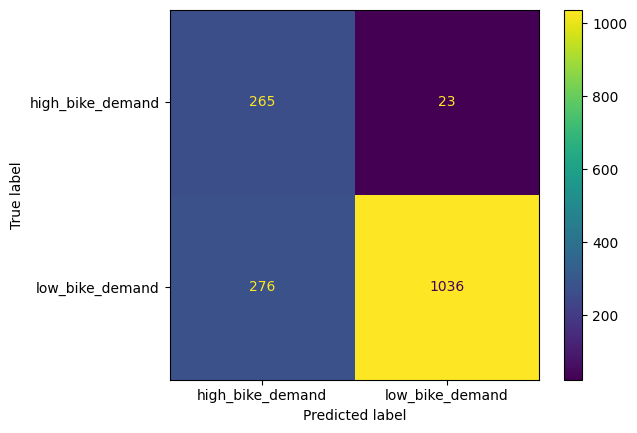

In [4]:
# - Cross-validation --------------------------------
pipeline = get_pipeline(final_model)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
y_pred = cross_val_predict(pipeline, X, y, cv=cv)

# Classification report
print(classification_report(y, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y, y_pred)
plt.show()

Diverse plots

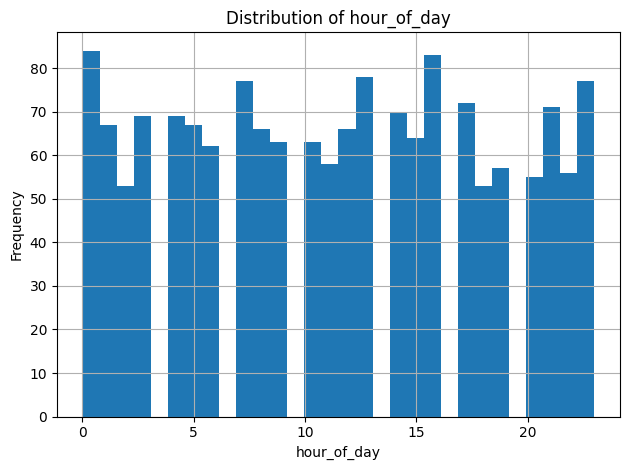

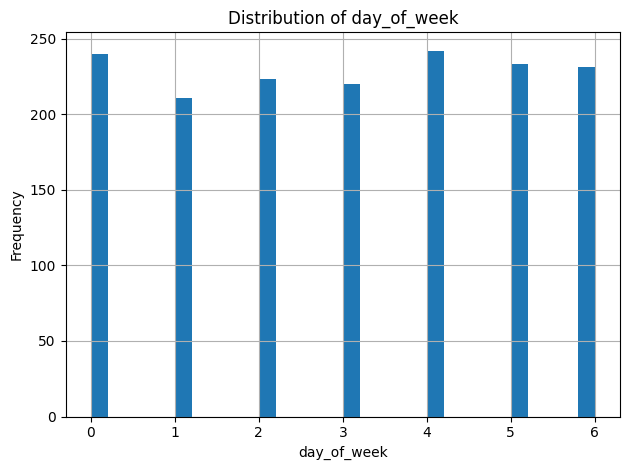

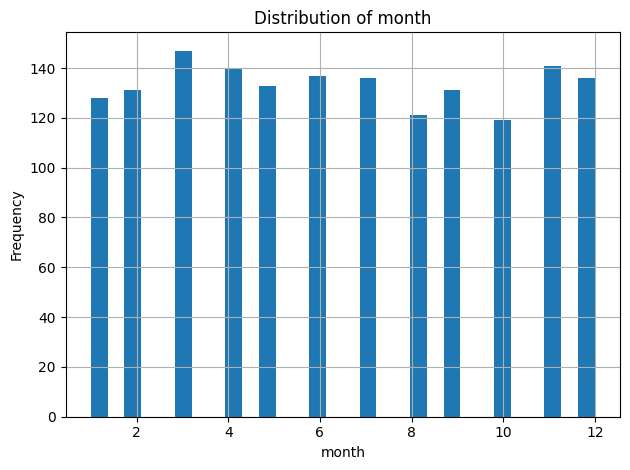

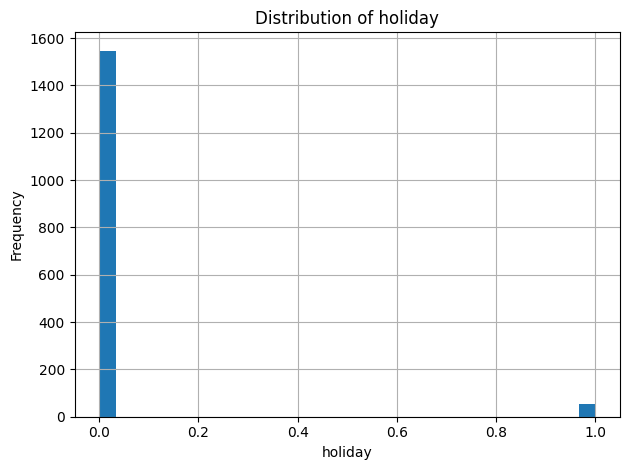

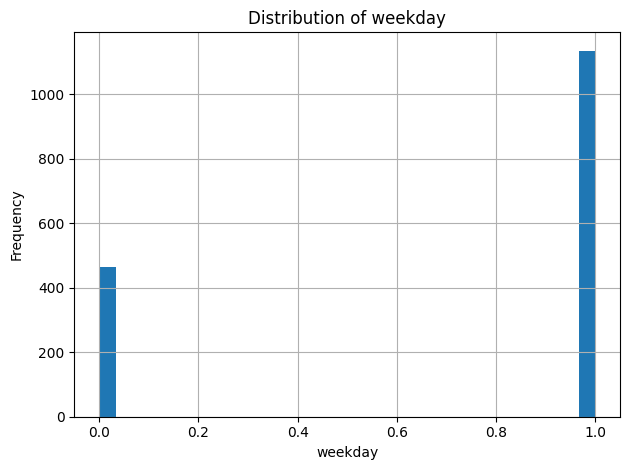

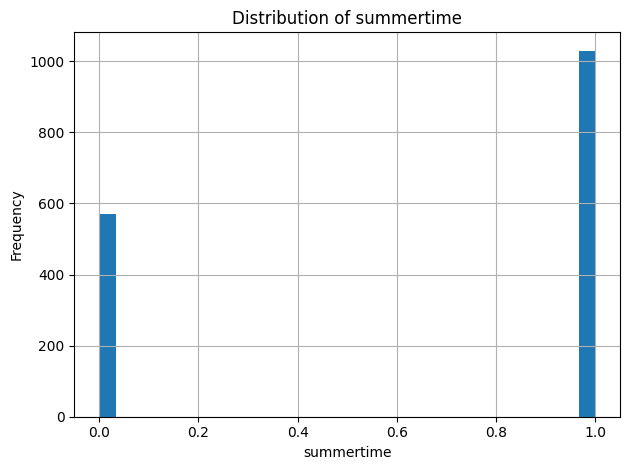

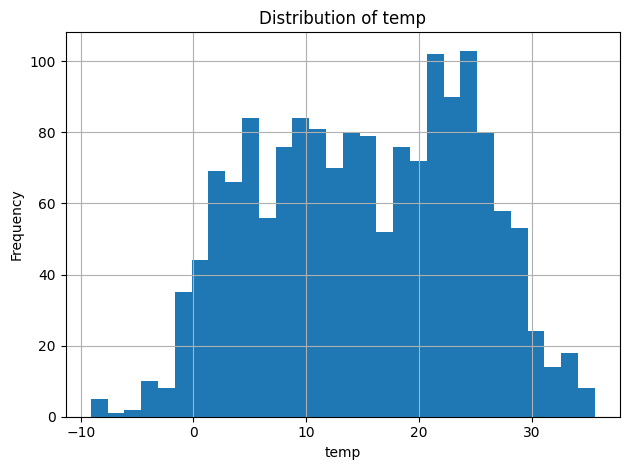

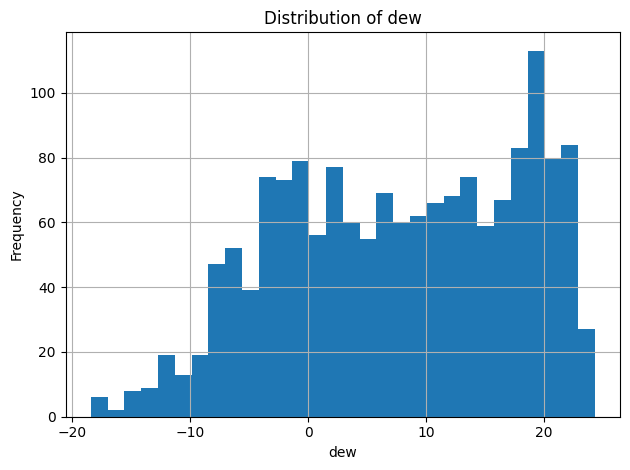

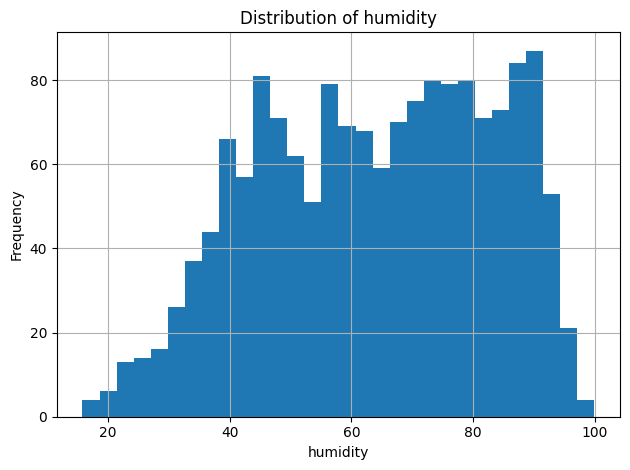

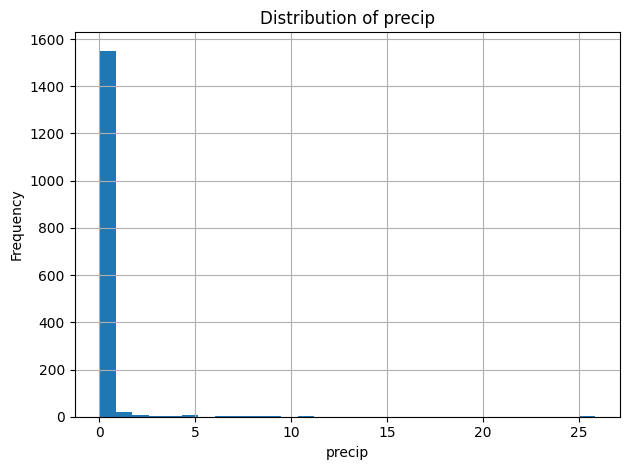

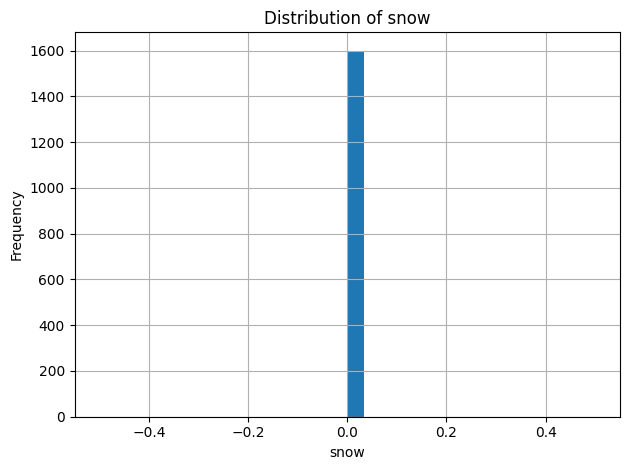

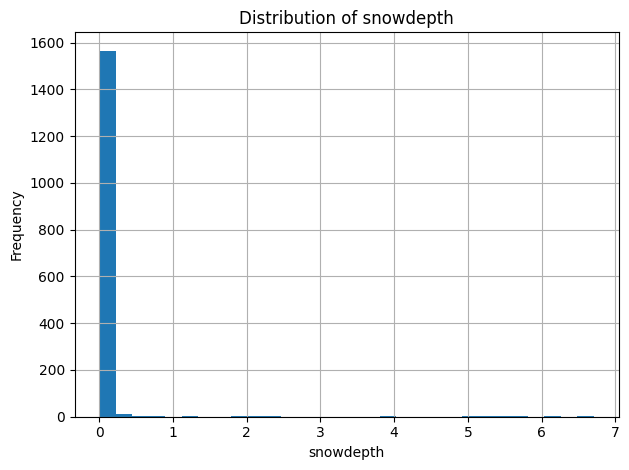

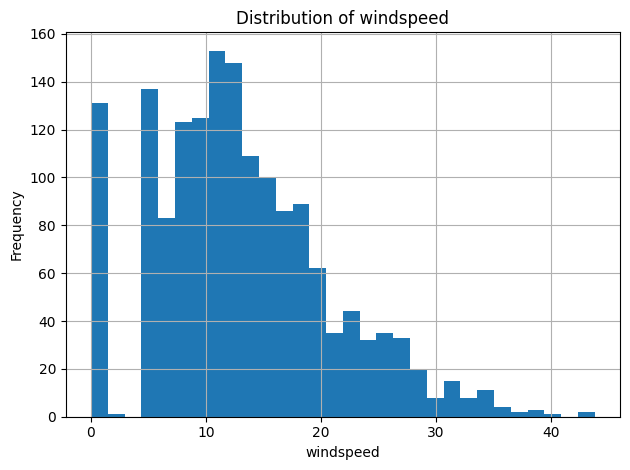

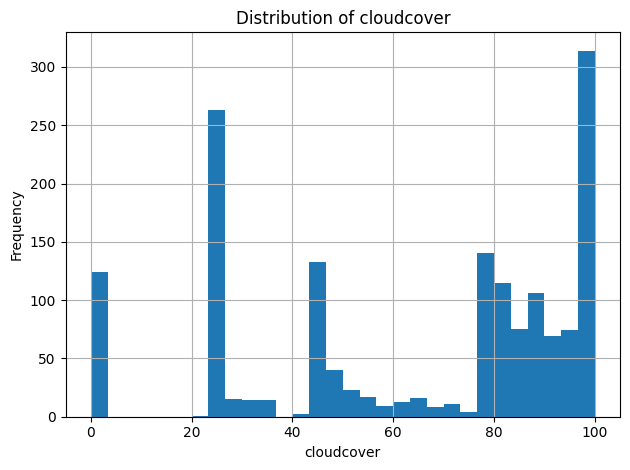

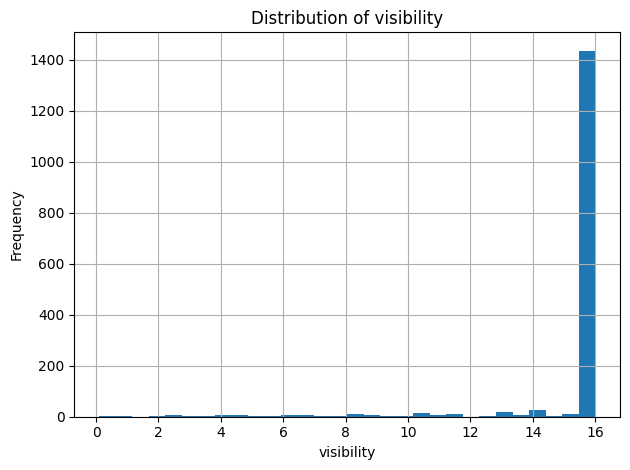

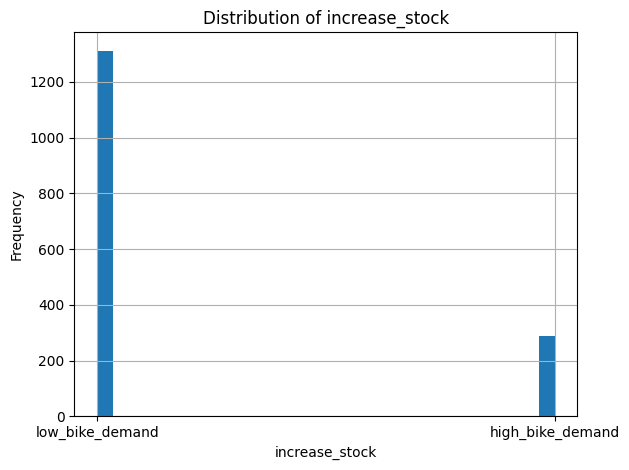

In [ ]:
# - Plot distributions ---------------------------
import pandas as pd
import matplotlib.pyplot as plt

# Läs in data
training_data = pd.read_csv("../training/training_data_VT2026.csv")

# Loopa över alla kolumner
for column in training_data.columns:
    
    plt.figure()
    
    if training_data[column].dtype == "object":
        # Kategorisk variabel → stapeldiagram
        training_data[column].value_counts().plot(kind="bar")
        plt.ylabel("Count")
        
    else:
        # Numerisk variabel → histogram
        training_data[column].hist(bins=30)
        plt.ylabel("Frequency")
    
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.tight_layout()
    plt.show()


<Figure size 600x400 with 0 Axes>

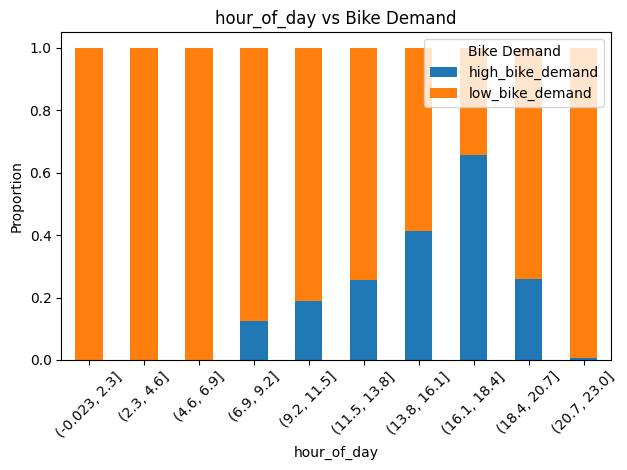

<Figure size 600x400 with 0 Axes>

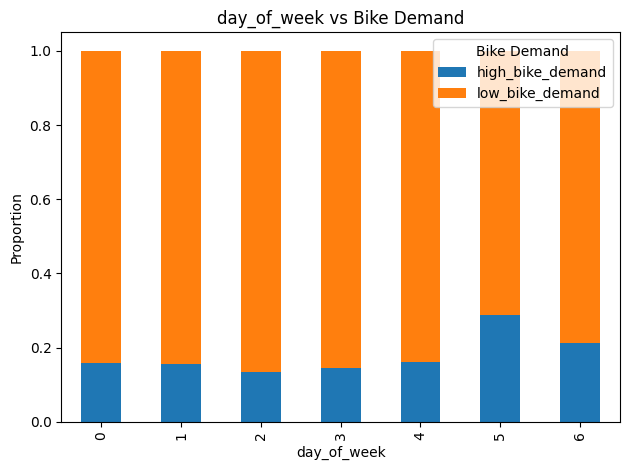

<Figure size 600x400 with 0 Axes>

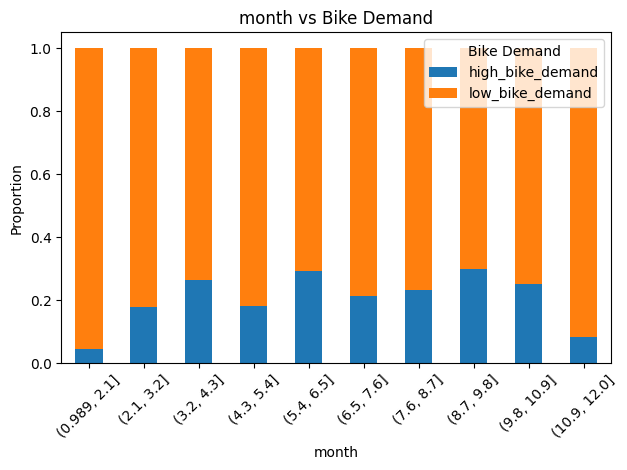

<Figure size 600x400 with 0 Axes>

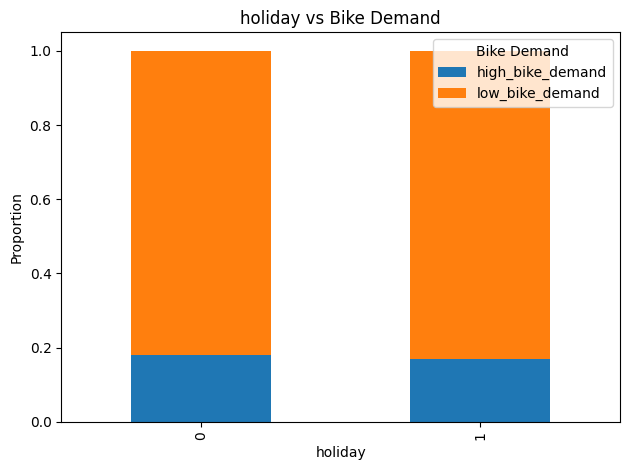

<Figure size 600x400 with 0 Axes>

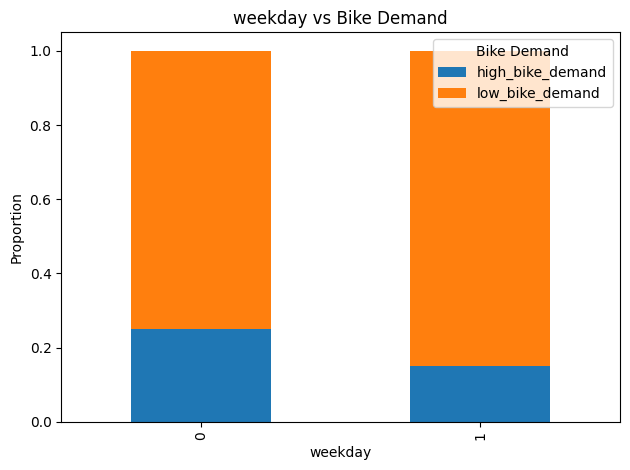

<Figure size 600x400 with 0 Axes>

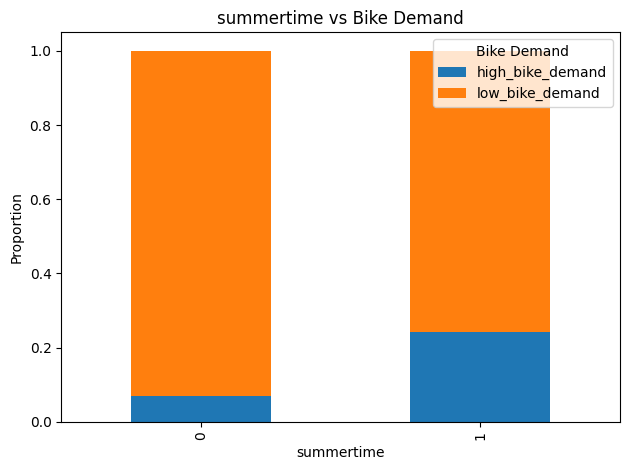

<Figure size 600x400 with 0 Axes>

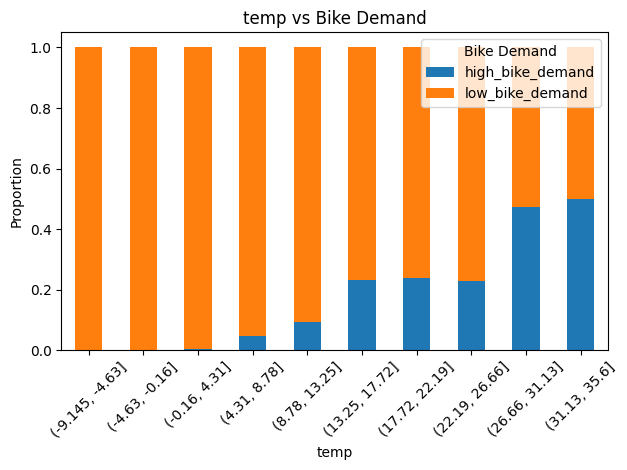

<Figure size 600x400 with 0 Axes>

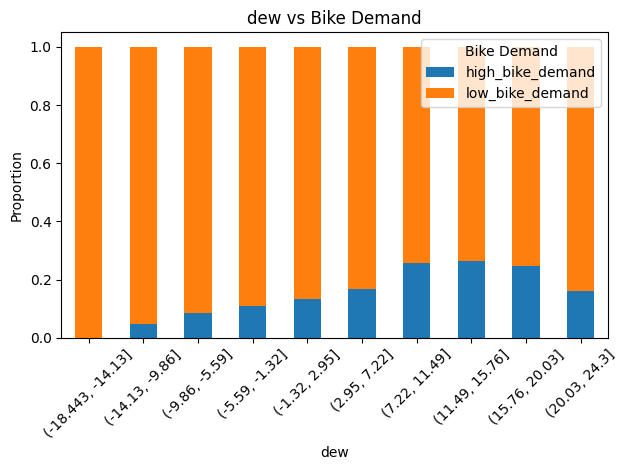

<Figure size 600x400 with 0 Axes>

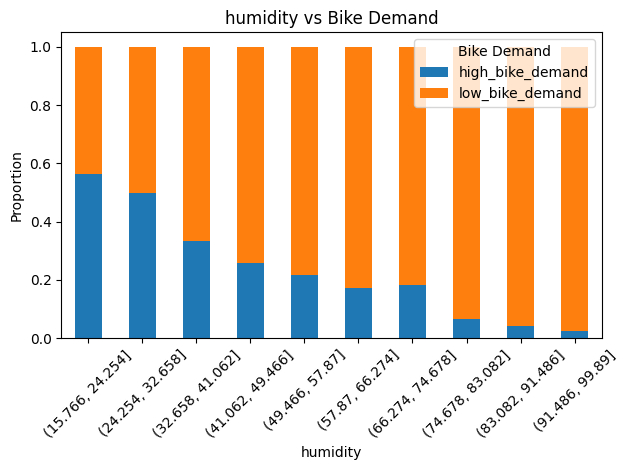

<Figure size 600x400 with 0 Axes>

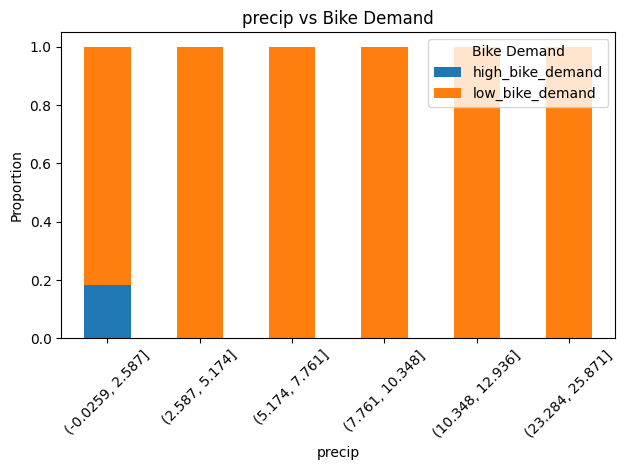

<Figure size 600x400 with 0 Axes>

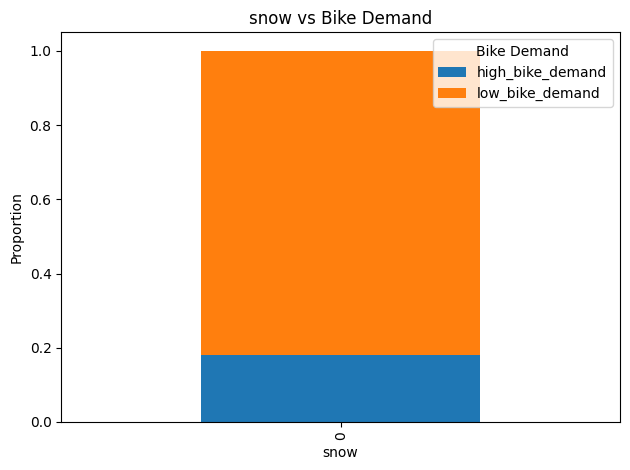

<Figure size 600x400 with 0 Axes>

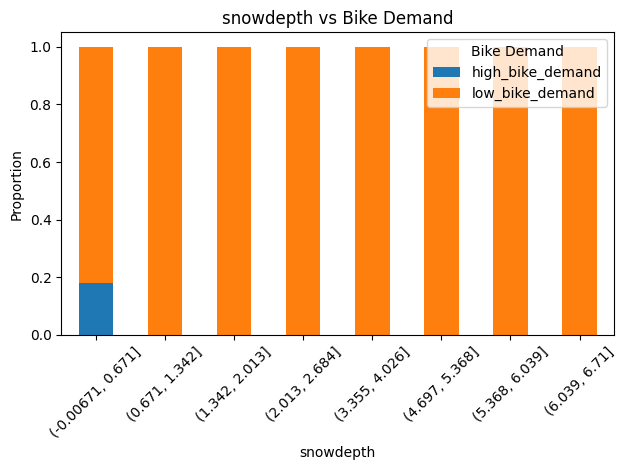

<Figure size 600x400 with 0 Axes>

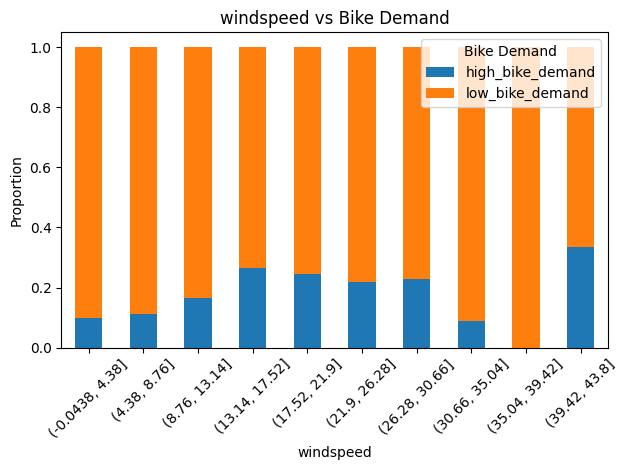

<Figure size 600x400 with 0 Axes>

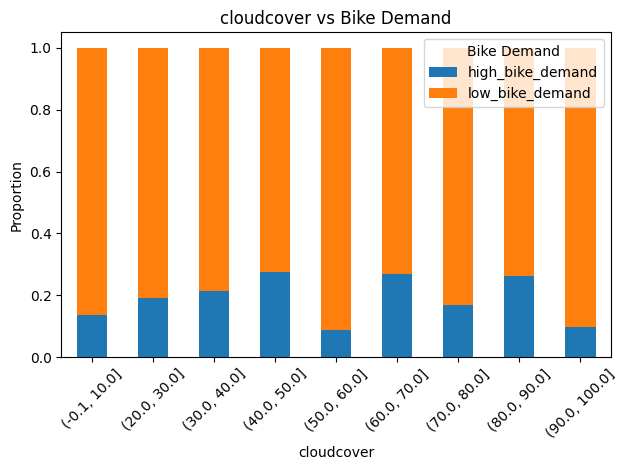

<Figure size 600x400 with 0 Axes>

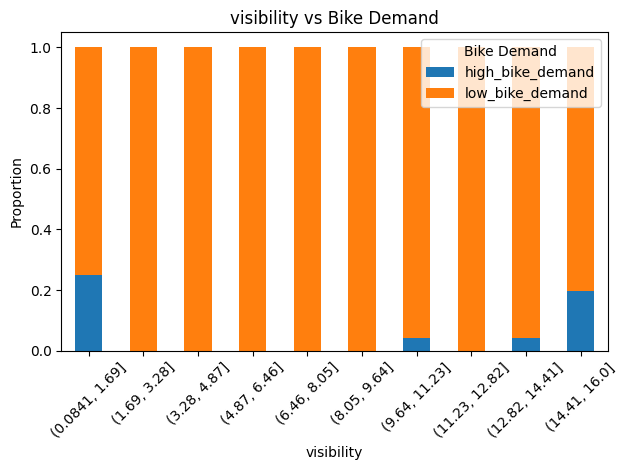

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Läs in data
training_data = pd.read_csv("../training/training_data_VT2026.csv")

# Lista features (exkludera target)
features = [c for c in training_data.columns if c != 'increase_stock']

for column in features:
    plt.figure(figsize=(6,4))
    
    # Kategorisk eller numerisk
    if training_data[column].dtype == "object" or training_data[column].nunique() < 10:
        # Kategorisk → direkt proportion per kategori
        prop = training_data.groupby(column)['increase_stock'].value_counts(normalize=True).unstack()
        prop.plot(kind='bar', stacked=True)
        plt.ylabel("Proportion")
        plt.xlabel(column)
        
    else:
        # Numerisk → dela upp i bins
        bins = 10
        training_data['bin'] = pd.cut(training_data[column], bins=bins)
        prop = training_data.groupby('bin')['increase_stock'].value_counts(normalize=True).unstack()
        prop.plot(kind='bar', stacked=True)
        plt.ylabel("Proportion")
        plt.xlabel(column)
        plt.xticks(rotation=45)
        training_data.drop(columns='bin', inplace=True)
    
    plt.title(f"{column} vs Bike Demand")
    plt.legend(title='Bike Demand')
    plt.tight_layout()
    plt.show()
